<a href="https://colab.research.google.com/github/ewilli400/Trump_Tweets/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime

In [2]:
#reading in the cleaned dataset
trump_tweets = pd.read_csv("https://github.com/ewilli400/trump/blob/main/out%20(4).csv?raw=true")
trump_tweets

,content,date,retweets,favorites,mentions,hashtags,target,insult,indicator,time,year
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,None,None,None,None,0.0,20:54:25,2009
1,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,None,None,None,None,0.0,03:00:10,2009
2,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,None,None,None,None,0.0,15:38:08,2009
3,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,None,None,None,None,0.0,22:40:15,2009
4,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,None,None,None,None,0.0,16:07:28,2009
...,...,...,...,...,...,...,...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,213817,None,None,None,None,0.0,19:24:52,2020
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,149571,None,None,michael-bloomberg,Mini Mike,1.0,22:12:20,2020
41119,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,66944,None,#,None,None,0.0,01:27:07,2020
41120,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,81921,@ @ @,None,None,None,0.0,02:16:00,2020


# **Machine Learning: Criticism**
Using K-Nearest-Neighbors, we train a model to attempt to predict if a given tweet contains a criticism based on the tf-idf of word-usage of his tweets.

In [3]:
trump_tweets_2014on = trump_tweets[trump_tweets['year'] > 2013] # Create a new dataframe of only 2014-2020 because 2014 is the earliest available data we have on cristicisms
trump_tweets_2014on

,content,date,retweets,favorites,mentions,hashtags,target,insult,indicator,time,year
13466,Today is the first day of the rest of your lif...,2014-01-01 13:56:30,854,696,None,None,None,None,0.0,13:56:30,2014
13467,This very expensive GLOBAL WARMING bullshit ha...,2014-01-02 01:39:56,7295,5670,None,None,None,None,0.0,01:39:56,2014
13468,""" @ ScreenPlayWritr: @ realDonaldTrump Is Al G...",2014-01-02 06:47:30,21,33,@ @,None,None,None,0.0,06:47:30,2014
13469,""" @ MeleMallory: @ realDonaldTrump You know it...",2014-01-02 07:00:04,64,79,@ @,None,None,None,0.0,07:00:04,2014
13470,""" @ noahshappy: @ realDonaldTrump very true co...",2014-01-02 07:02:48,29,55,@ @,None,None,None,0.0,07:02:48,2014
...,...,...,...,...,...,...,...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,213817,None,None,None,None,0.0,19:24:52,2020
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,149571,None,None,michael-bloomberg,Mini Mike,1.0,22:12:20,2020
41119,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,66944,None,#,None,None,0.0,01:27:07,2020
41120,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,81921,@ @ @,None,None,None,0.0,02:16:00,2020


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Create randomized training and testing sets from the full data set (randomized to account for the affect of time on his word use)
tweets_train_df = trump_tweets_2014on.sample(frac = 0.95)
tweets_test_df = trump_tweets_2014on.drop(tweets_train_df.index)

In [5]:
# Create a training documnet series
tr_content_docs = tweets_train_df['content'].squeeze()
tr_content_docs = tr_content_docs.reset_index(drop=True)
tr_content_docs

0        " @ linnie13: @ greta @ realDonaldTrump @ FoxN...
1        " @ JoeQuinn6: @ realDonaldTrump America needs...
2        However beautiful the strategy, you should occ...
3        Great poll out of Nevada- thank you! See you s...
4        We only want to admit those who love our peopl...
                               ...                        
26268    America’s greatest treasure is our people – an...
26269    "@UmpireRobert: @ realDonaldTrump is this one ...
26270    “Age is whatever you think it is. You are as o...
26271    “You have to learn the rules of the game. And ...
26272    " @ OfficialTentBoy: Even young conservatives ...
Name: content, Length: 26273, dtype: object

In [6]:
# Create test document series
te_content_docs = tweets_test_df['content'].squeeze()
te_content_docs = te_content_docs.reset_index(drop=True)
te_content_docs

0       Record snowfall & freezing temps throughout th...
1       Entrepreneurs: Set the example and you'll be a...
2       We had a GREAT year @ Macys with ties, shirts ...
3       " @ 18_4_LIFE: @ realDonaldTrump @caleb2207 Yo...
4       President Obama just fired the ObamaCare websi...
                              ...                        
1378    ....and, if Republicans win in court and take ...
1379    We are helping Apple all of the time on TRADE ...
1380    Mini Mike Bloomberg doesn’t get on the Democra...
1381    They are rigging the election again against Be...
1382    ....Joe Biden, and Bernie is shut out again. V...
Name: content, Length: 1383, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def predict_criticism(train_docs, test_docs, test_df):
  vec = TfidfVectorizer(norm=None)
  vec.fit(train_docs) # Train the vectorizer with the training documents
  tfidf_sparse = vec.transform(test_docs) # Transform the testing documents with the fitted vectorizer
  df_predict = pd.DataFrame(columns=['index', 'tweet', 'criticism']) # Create a dataframe to organize the results
  c = 0
  for i in range(0, len(test_docs)):
    sim = pd.DataFrame(cosine_similarity(tfidf_sparse)[i]) # Create a dataframe with the cosine similarities between the test data point and the training data
    sim.columns = ["cos"]
    most_sim = sim.sort_values(by='cos', ascending=False) # Sort the cosine similarities in descending order
    index = most_sim[1: 6].index # Find the 5 most similar neighbors (excluding index 0 as that is the cosine similarity between the test document and itself)
    criticisms_ = []
    for j in index:
      criticisms_ += [test_df.iloc[j]["indicator"]] # Add the indicator of each neighbor
    df_criticism_count = pd.DataFrame({'Criticism': criticisms_})
    criticism_ = df_criticism_count["Criticism"].value_counts().idxmax() # Find the most common indicator of all neighbors
    content = test_df.iloc[i]['content']
    df_predict.loc[c] = [i, content, criticism_]
    c += 1
  return df_predict

In [8]:
df_predict = predict_criticism(tr_content_docs, te_content_docs, tweets_test_df)
df_predict["criticism"].value_counts()

0.0    1339
1.0      44
Name: criticism, dtype: int64

In [9]:
predict = tweets_test_df.merge(df_predict, how="left", left_on="content", right_on="tweet")
predict["correct"] = predict["indicator"] - predict["criticism"]
predict["correct"].value_counts(normalize=True)

 0.0    0.917690
 1.0    0.063538
-1.0    0.018773
Name: correct, dtype: float64

**Accuracy: ~91%**

# **Machine Learning: Time of Day**
Using K-Nearest-Neighbors, we train a model to attempt to predict what time of day a tweet was sent based on the tf-idf of word-usage of his tweets.

In [10]:
# A map to create a "time of day" column which splits the hours of the day into four, six-hour time chunks
def time_of_day(c):
  time = int(c[:2])
  if 4 <= time < 10:
    return "Morning"
  elif 10 <= time < 16:
    return "Midday"
  elif 16 <= time < 22:
    return "Evening"
  else:
    return "Night"

In [11]:
# A map to create an "indicator" number for each time chunk
def to_number(c):
  if c == "Morning":
    return 1
  elif c == "Midday":
    return 2
  elif c == "Evening":
    return 3
  else:
    return 4

In [12]:
# Apply above maps
trump_tweets["time of day"] = trump_tweets['time'].map(time_of_day)
trump_tweets['time indicator'] = trump_tweets['time of day'].map(to_number)
trump_tweets

,content,date,retweets,favorites,mentions,hashtags,target,insult,indicator,time,year,time of day,time indicator
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,None,None,None,None,0.0,20:54:25,2009,Evening,3
1,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,None,None,None,None,0.0,03:00:10,2009,Night,4
2,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,None,None,None,None,0.0,15:38:08,2009,Midday,2
3,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,None,None,None,None,0.0,22:40:15,2009,Night,4
4,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,None,None,None,None,0.0,16:07:28,2009,Evening,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,213817,None,None,None,None,0.0,19:24:52,2020,Evening,3
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,149571,None,None,michael-bloomberg,Mini Mike,1.0,22:12:20,2020,Night,4
41119,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,66944,None,#,None,None,0.0,01:27:07,2020,Night,4
41120,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,81921,@ @ @,None,None,None,0.0,02:16:00,2020,Night,4


In [13]:
# Create randomized training and testing sets from the full data set (randomized to account for the affect of time on his word use)
tweets_train_df = trump_tweets.sample(frac = 0.95)
tweets_test_df = trump_tweets.drop(tweets_train_df.index)

In [14]:
# Create a training documnet series
tr_content_docs = tweets_train_df['content'].squeeze()
tr_content_docs = tr_content_docs.reset_index(drop=True)
tr_content_docs

0        Today in Alaska, it was my great honor to visi...
1        " @ userback: @ realDonaldTrump @ realJoeMurra...
2        The Democrats have been told, and fully unders...
3        Via @DC_Decoder: "Donald Trump to 'surprise' G...
4        President Obama - close down the flights from ...
                               ...                        
39061    " @ EastonWestwood: It's PATHETIC for @ JonahN...
39062    Wow! What a great night. Thank you to all of t...
39063    ....financial gain is a Federal Gratuity Statu...
39064    Are all the illegals pouring into our country ...
39065    To aspiring entrepreneurs: Be focused! Know yo...
Name: content, Length: 39066, dtype: object

In [15]:
# Create test document series
te_content_docs = tweets_test_df['content'].squeeze()
te_content_docs = te_content_docs.reset_index(drop=True)
te_content_docs

0       Be sure to tune in and watch Donald Trump on L...
1       "Always know you could be on the precipice of ...
2       "Keep it fast, short and direct - whatever it ...
3       Browse Donald Trump's Summer Reading List for ...
4       Golf Channel & Donald Trump's World of Golf ho...
                              ...                        
2051    We love Australia!https://twitter.com/ScottMor...
2052    I love constantly proving them wrong. It’s eas...
2053    Congratulations to @ serenawilliams on another...
2054    Steyer is running low on cash. Nobody knows hi...
2055    Here we go again, another Con Job by the Do No...
Name: content, Length: 2056, dtype: object

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

def predict_time(train_docs, test_docs, test_df):
  vec = TfidfVectorizer(norm=None)
  vec.fit(train_docs) # Train the vectorizer with the training documents
  tfidf_sparse = vec.transform(test_docs) # Transform the testing documents with the fitted vectorizer
  df_predict = pd.DataFrame(columns=['index', 'tweet', 'time of day', 'avg time indicator']) # Create a dataframe to organize the results
  c = 0
  for i in range(0, len(test_docs)):
    sim = pd.DataFrame(cosine_similarity(tfidf_sparse)[i]) # Create a dataframe with the cosine similarities between the test data point and the training data
    sim.columns = ["cos"]
    most_sim = sim.sort_values(by='cos', ascending=False) # Sort the cosine similarities in descending order
    index = most_sim[1: 6].index # Find the 5 most similar neighbors (excluding index 0 as that is the cosine similarity between the test document and itself)
    times_ = []
    indicators_ = []
    for j in index:
      times_ += [test_df.iloc[j]["time of day"]] # Add the time of day for each neighbor
      indicators_ += [test_df.iloc[j]['time indicator']] #Add the indicator variable for each neighbor
    df_time_count = pd.DataFrame({'Time': times_})
    time_ = df_time_count["Time"].value_counts().idxmax() # Find the most frequent time of day of similar neighbors
    indicator_c = 0
    for k in indicators_:
      indicator_c += k
    indicator_ = indicator_c / (len(indicators_)) # Find the average indicator of similar neighbors
    content = test_df.iloc[i]['content']
    df_predict.loc[c] = [i, content, time_, indicator_]
    c += 1
  return df_predict

In [17]:
df_predict = predict_time(tr_content_docs, te_content_docs, tweets_test_df)

In [18]:
df_predict['abs time indicator'] = df_predict['time of day'].map(to_number) # Apply the map to create the absolute indicators

In [19]:
df_predict["time of day"].value_counts()

Evening    957
Night      536
Midday     450
Morning    113
Name: time of day, dtype: int64

In [20]:
predict = tweets_test_df.merge(df_predict, how="left", left_on="content", right_on="tweet") # Merge the two DataFrames
predict["avg correct"] = predict["time indicator"] - predict["avg time indicator"]
predict['avg correct'] = predict['avg correct'].round(decimals=1)
avg_vals = predict["avg correct"].value_counts(normalize=True)
avg_vals

-0.4    0.079767
 0.0    0.076362
 0.4    0.074903
-0.2    0.069553
 0.2    0.065661
 1.0    0.063716
 0.8    0.059339
 0.6    0.057393
-0.6    0.056420
-0.8    0.055447
 1.2    0.049125
 1.4    0.040856
-1.2    0.039883
-1.0    0.037938
 1.6    0.024805
-1.6    0.024319
-1.4    0.021887
-1.8    0.020428
-2.0    0.019942
 1.8    0.015564
 2.0    0.009728
-2.2    0.009241
-2.4    0.008755
 2.2    0.007782
-2.6    0.003405
 2.4    0.002918
-2.8    0.001946
 2.8    0.001459
 2.6    0.000973
-3.0    0.000486
Name: avg correct, dtype: float64

In [21]:
predict["abs correct"] = predict["time indicator"] - predict["abs time indicator"]
abs_vals = predict['abs correct'].value_counts(normalize=True)
abs_vals

 0    0.366245
-1    0.208171
 1    0.203794
-2    0.099708
 2    0.068093
-3    0.038424
 3    0.015564
Name: abs correct, dtype: float64

Text(0, 0.5, 'Frequency')

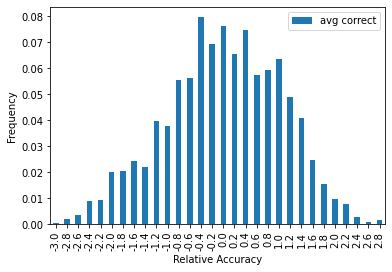

In [22]:
import matplotlib.pyplot as plt 

avg_vals_df = pd.DataFrame(avg_vals)
avg_vals_df = avg_vals_df.sort_index()
avg_vals_df.plot.bar()
plt.xlabel("Relative Accuracy")
plt.ylabel("Frequency")

As seen by the graph, it is most common for the model to predict a time of day closer to the actual time of day, creating a rough bell-curve shape with perfect accuracy as the mean. As seen below, some predictions that had correctness values of +-0.2 or +-0.4 had the correct time-of-day prediction.

The overall accuracy of the absolute labels of the model is **~37%**.

In [23]:
predict

,content,date,retweets,favorites,mentions,hashtags,target,insult,indicator,time,year,time of day_x,time indicator,index,tweet,time of day_y,avg time indicator,abs time indicator,avg correct,abs correct
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,None,None,None,None,0.0,20:54:25,2009,Evening,3,0,Be sure to tune in and watch Donald Trump on L...,Evening,3.2,3,-0.2,0
1,"""Always know you could be on the precipice of ...",2009-05-20 15:25:39,29,53,None,None,None,None,0.0,15:25:39,2009,Midday,2,1,"""Always know you could be on the precipice of ...",Evening,2.6,3,-0.6,-1
2,"""Keep it fast, short and direct - whatever it ...",2009-05-22 04:59:39,52,70,None,None,None,None,0.0,04:59:39,2009,Morning,1,2,"""Keep it fast, short and direct - whatever it ...",Midday,1.8,2,-0.8,-1
3,Browse Donald Trump's Summer Reading List for ...,2009-08-04 15:50:58,32,18,None,None,None,None,0.0,15:50:58,2009,Midday,2,3,Browse Donald Trump's Summer Reading List for ...,Midday,2.4,2,-0.4,0
4,Golf Channel & Donald Trump's World of Golf ho...,2010-01-22 21:51:00,18,3,@TNGC,None,None,None,0.0,21:51:00,2010,Evening,3,4,Golf Channel & Donald Trump's World of Golf ho...,Evening,3.0,3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,We love Australia!https://twitter.com/ScottMor...,2020-01-07 12:44:32,25144,177643,None,None,None,None,0.0,12:44:32,2020,Midday,2,2051,We love Australia!https://twitter.com/ScottMor...,Evening,2.8,3,-0.8,-1
2052,I love constantly proving them wrong. It’s eas...,2020-01-10 16:31:27,18286,78875,None,None,None,None,0.0,16:31:27,2020,Evening,3,2052,I love constantly proving them wrong. It’s eas...,Evening,2.6,3,0.4,0
2053,Congratulations to @ serenawilliams on another...,2020-01-12 14:28:34,8531,52465,@,None,None,None,0.0,14:28:34,2020,Midday,2,2053,Congratulations to @ serenawilliams on another...,Evening,2.8,3,-0.8,-1
2054,Steyer is running low on cash. Nobody knows hi...,2020-01-15 05:46:25,16408,63212,None,None,None,None,0.0,05:46:25,2020,Morning,1,2054,Steyer is running low on cash. Nobody knows hi...,Evening,2.2,3,-1.2,-2


# **Machine Learning: Year**
Using K-Nearest-Neighbors, we train a model to predict in what year a tweet was tweeted based on the tf-idf of word-usage of his tweets.

In [24]:
# Create randomized training and testing sets from the full data set (randomized to account for the affect of time on his word use)
tweets_train_df = trump_tweets.sample(frac = 0.95)
tweets_test_df = trump_tweets.drop(tweets_train_df.index)

In [25]:
# Create a training documnet series
tr_content_docs = tweets_train_df['content'].squeeze()
tr_content_docs = tr_content_docs.reset_index(drop=True)
tr_content_docs

0        “You don’t see a direct quid pro quo in this.”...
1        Nobody understands politicians like I do - all...
2        The Democratic National Committee, sometimes r...
3        Just stopped in Alaska and said hello to our G...
4        " @ TanmayShekhawat: @ realDonaldTrump was inc...
                               ...                        
39061    The Queen of Soul, Aretha Franklin, is dead. S...
39062    The ALS # IceBucketChallenge that Trumps them ...
39063    Miss Universe, @ Dayanamendoza, will be on the...
39064    "@Co: CBS reports "swarms" of celebrators were...
39065    "@birchtrees47: @ realDonaldTrump cause there ...
Name: content, Length: 39066, dtype: object

In [26]:
# Create test document series
te_content_docs = tweets_test_df['content'].squeeze()
te_content_docs = te_content_docs.reset_index(drop=True)
te_content_docs

0       Hear Donald Trump discuss big gov spending, ba...
1       From Donald Trump: Wishing everyone a wonderfu...
2       Superbowl Sunday is a great American tradition...
3       The new season of the Celebrity Apprentice is ...
4       Scotland is beautiful. I spent several years l...
                              ...                        
2051    THANK YOU TOLEDO, OHIO!https://twitter.com/i/b...
2052    “FBI Director apologizes for FISA Errors (of w...
2053    Nancy Pelosi will go down as the absolute wors...
2054    Wow! The wonderful Iranian protesters refused ...
2055    The Fake News Media and their Democrat Partner...
Name: content, Length: 2056, dtype: object

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def predict_year(train_docs, test_docs, test_df):
  vec = TfidfVectorizer(norm=None)
  vec.fit(train_docs) # Train the vectorizer with the training documents
  tfidf_sparse = vec.transform(test_docs) # Transform the testing documents with the fitted vectorizer
  df_predict = pd.DataFrame(columns=['index', 'tweet', 'year']) # Create a dataframe to organize the results
  c = 0
  for i in range(0, len(test_docs)):
    sim = pd.DataFrame(cosine_similarity(tfidf_sparse)[i]) # Create a dataframe with the cosine similarities between the test data point and the training data
    sim.columns = ["cos"]
    most_sim = sim.sort_values(by='cos', ascending=False) # Sort the cosine similarities in descending order
    index = most_sim[1: 6].index # Find the 5 most similar neighbors (excluding index 0 as that is the cosine similarity between the test document and itself)
    years_ = []
    for j in index:
      years_ += [test_df.iloc[j]["year"]] # Add the year of each neighbor
    df_year_count = pd.DataFrame({'Year': years_})
    year_ = df_year_count["Year"].value_counts().idxmax() # Find the most common year of all neighbors
    content = test_df.iloc[i]['content']
    df_predict.loc[c] = [i, content, year_]
    c += 1
  return df_predict

In [28]:
df_predict = predict_year(tr_content_docs, te_content_docs, tweets_test_df)

In [29]:
predict = tweets_test_df.merge(df_predict, how="left", left_on="content", right_on="tweet")
predict["correct"] = predict["year_x"] - predict["year_y"]
predict["correct"].value_counts(normalize=True)

 0    0.385326
-1    0.151118
 1    0.128280
-2    0.084062
 2    0.063168
 4    0.036443
-3    0.035471
 3    0.035471
-4    0.025267
 5    0.018950
-5    0.013120
 6    0.009232
-6    0.006317
-7    0.003401
 7    0.002915
-8    0.000972
 9    0.000486
Name: correct, dtype: float64

**Accuracy: ~40%**

The frequency of the model prediciting other years gets less and less common the farther away the predicited year is.